### SECTION - A

In [10]:
import random
import os
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

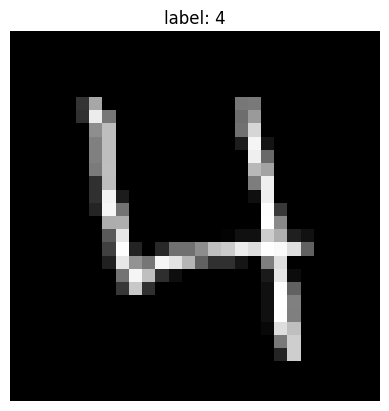

In [12]:
# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for CNN input
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

rn = random.randint(0, len(x_train))

plt.imshow(x_train[rn], cmap='gray')
plt.title(f'label: {y_train[rn]}')
plt.axis('off')
plt.show()

In [13]:
# Create a dataset with rotated images
def rotate_images(images, labels):
    rotated_images = []
    rotated_labels = []
    
    for image, label in zip(images, labels):
        # Original image (0 degrees)
        rotated_images.append(image)
        rotated_labels.append(label)
        
        # Rotate 90 degrees
        rot_90 = tf.image.rot90(image)
        rotated_images.append(rot_90)
        rotated_labels.append(label)
        
        # Rotate 180 degrees
        rot_180 = tf.image.rot90(rot_90)
        rotated_images.append(rot_180)
        rotated_labels.append(label)
        
        # Rotate 270 degrees
        rot_270 = tf.image.rot90(rot_180)
        rotated_images.append(rot_270)
        rotated_labels.append(label)
    
    return np.array(rotated_images), np.array(rotated_labels)

In [14]:
# Create rotated datasets
x_train_rot, y_train_rot = rotate_images(x_train[:10000], y_train[:10000])
x_test_rot, y_test_rot = rotate_images(x_test[:1000], y_test[:1000])

print('X-TRAIN: ')
print(x_train_rot.shape, y_train_rot.shape)

print('X-TEST: ')
print(x_test_rot.shape, y_test_rot.shape)

X-TRAIN: 
(40000, 28, 28, 1) (40000,)
X-TEST: 
(4000, 28, 28, 1) (4000,)


In [15]:
# Custom rotation-equivariant layer
class RotationEquivariantLayer(layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(RotationEquivariantLayer, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        
        # Create a single convolutional layer that will be shared
        self.conv = layers.Conv2D(filters, kernel_size, padding='same')
        
    def call(self, inputs):
        # Original orientation (0 degrees)
        x_0 = self.conv(inputs)
        
        # Rotate input 90 degrees, apply conv, then rotate output back
        x_90 = tf.image.rot90(inputs, k=1)
        x_90 = self.conv(x_90)
        x_90 = tf.image.rot90(x_90, k=3)  # Rotate back (270 degrees)
        
        # Rotate input 180 degrees, apply conv, then rotate output back
        x_180 = tf.image.rot90(inputs, k=2)
        x_180 = self.conv(x_180)
        x_180 = tf.image.rot90(x_180, k=2)  # Rotate back (180 degrees)
        
        # Rotate input 270 degrees, apply conv, then rotate output back
        x_270 = tf.image.rot90(inputs, k=3)
        x_270 = self.conv(x_270)
        x_270 = tf.image.rot90(x_270, k=1)  # Rotate back (90 degrees)
        
        # Average the outputs (this gives rotation equivariance)
        return (x_0 + x_90 + x_180 + x_270) / 4
    
    def get_config(self):
        config = super(RotationEquivariantLayer, self).get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size
        })
        return config

In [16]:
# Verify the layer's equivariance property
def test_equivariance():
    # Create a test image
    test_image = x_test[0:1]
    
    # Create rotated versions
    rot_90 = tf.image.rot90(test_image)
    rot_180 = tf.image.rot90(rot_90)
    rot_270 = tf.image.rot90(rot_180)
    
    # Create layer instance
    layer = RotationEquivariantLayer(16, (3, 3))
    
    # Apply layer to each rotation
    output_0 = layer(test_image)
    output_90 = layer(rot_90)
    output_180 = layer(rot_180)
    output_270 = layer(rot_270)
    
    # Rotate outputs to compare
    rotated_output_90 = tf.image.rot90(output_90, k=3)
    rotated_output_180 = tf.image.rot90(output_180, k=2)
    rotated_output_270 = tf.image.rot90(output_270, k=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(7, 7))
    
    axs[0].imshow(output_0[0, :, :, 0], cmap = 'gray')
    axs[1].imshow(rotated_output_90[0, :, :, 0], cmap = 'gray')
    axs[0].set_title('output_0')
    axs[1].set_title('rotated_output_90')

    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(7, 7))
    
    axs[0].imshow(output_0[0, :, :, 0], cmap = 'gray')
    axs[1].imshow(rotated_output_180[0, :, :, 0], cmap = 'gray')
    axs[0].set_title('output_0')
    axs[1].set_title('rotated_output_180')
    
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(7, 7))
    
    axs[0].imshow(output_0[0, :, :, 0], cmap = 'gray')
    axs[1].imshow(rotated_output_270[0, :, :, 0], cmap = 'gray')
    axs[0].set_title('output_0')
    axs[1].set_title('rotated_output_270')
    
    plt.show()
    
    # Check if outputs are similar (should be nearly identical for perfect equivariance)
    diff_90 = tf.reduce_mean(tf.abs(output_0 - rotated_output_90))
    diff_180 = tf.reduce_mean(tf.abs(output_0 - rotated_output_180))
    diff_270 = tf.reduce_mean(tf.abs(output_0 - rotated_output_270))
    
    print(f"Mean absolute difference (0° vs 90°): {diff_90.numpy()}")
    print(f"Mean absolute difference (0° vs 180°): {diff_180.numpy()}")
    print(f"Mean absolute difference (0° vs 270°): {diff_270.numpy()}")
    
    return diff_90.numpy(), diff_180.numpy(), diff_270.numpy()


In [ ]:
# Create regular CNN model
class RegularModel(keras.models.Model):
    def __init__(self, num_class=10, input_shape=(28, 28, 1), kernel_size=(3, 3), output_size=[32, 64, 128]):
        super(RegularModel, self).__init__()
        
        self.conv1 = layers.Conv2D(output_size[0], kernel_size=kernel_size, activation=None, input_shape=input_shape)
        self.conv2 = layers.Conv2D(output_size[1], kernel_size=kernel_size, activation=None)
        self.conv3 = layers.Conv2D(output_size[-1], kernel_size=kernel_size, activation=None)
        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(num_class, activation='softmax')
    
    def call(self, x, is_visual=False):
        x_conv1 = self.conv1(x)
        x = layers.Activation('relu')(x_conv1)
        x = layers.MaxPooling2D((2, 2))(x)
        
        x_conv2 = self.conv2(x)
        x = layers.Activation('relu')(x_conv2)
        
        x_conv3 = self.conv3(x)
        x = layers.Activation('relu')(x_conv3)
        x = layers.MaxPooling2D((2, 2))(x)
        
        x = layers.Flatten()(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        
        if is_visual:
            return x_conv1, x_conv2, x_conv3
        
        return x
    
    def visual(self, x_conv):
        '''
        Plots the Evolution of Response Maps (by Convolution Layers)
        '''
        x_conv1, x_conv2, x_conv3 = x_conv
        
        fig, axs = plt.subplots(1, 3, figsize=(6, 6))
        
        axs[0].imshow(x_conv1[0, :, :, 0], cmap='gray')
        axs[1].imshow(x_conv2[0, :, :, 0], cmap='gray')
        axs[2].imshow(x_conv3[0, :, :, 0], cmap='gray')
        
        axs[0].set_title('Conv-Layer-1')
        axs[1].set_title('Conv-Layer-2')
        axs[2].set_title('Conv-Layer-3')

        plt.tight_layout(pad = 1)
        plt.show()

regular_model = RegularModel()
regular_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create equivariant CNN model
class EquivariantModel(keras.models.Model):
    def __init__(self, num_class = 10, input_shape = (28, 28, 1), kernel_size = (3, 3), output_size = [32, 64, 128]):
        super(EquivariantModel, self).__init__()
        
        self.eq_layer_1 = RotationEquivariantLayer(filters=output_size[0], kernel_size=kernel_size, input_shape=input_shape)
        self.eq_layer_2 = RotationEquivariantLayer(filters=output_size[1], kernel_size=kernel_size)
        self.eq_layer_3 = RotationEquivariantLayer(filters=output_size[-1], kernel_size=kernel_size)
        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(num_class, activation='softmax')

    
    def call(self, x, is_visual=False):
        
        x_eq_1 = self.eq_layer_1(x)
        x = layers.Activation('relu')(x_eq_1) ## NO params here
        x = layers.MaxPooling2D((2, 2))(x)

        x_eq_2 = self.eq_layer_2(x)
        x = layers.Activation('relu')(x_eq_2) ## NO params here
        
        x_eq_3 = self.eq_layer_3(x)
        x = layers.Activation('relu')(x_eq_3) ## NO params here
        x = layers.MaxPooling2D((2, 2))(x)
        
        x = layers.Flatten()(x)
        x = self.dense_1(x)
        x = self.dense_2(x)

        if is_visual:
             return x_eq_1, x_eq_2, x_eq_3

        return x
    
    def visual(self, x_eq):
        '''
        Plots the Evolution of Response Maps (by Equivariance Layers)
        '''
        x_eq_1, x_eq_2, x_eq_3 = x_eq

        fig, axs = plt.subplots(1, 3, figsize=(6, 6))
        
        axs[0].imshow(x_eq_1[0, :, :, 0], cmap='gray')
        axs[1].imshow(x_eq_2[0, :, :, 0], cmap='gray')
        axs[2].imshow(x_eq_3[0, :, :, 0], cmap='gray')

        axs[0].set_title('Equivariance-Layer-1')
        axs[1].set_title('Equivariance-Layer-2')
        axs[2].set_title('Equivariance-Layer-3')

        plt.tight_layout(pad = 2)
        plt.show()

class ResponseMapVisualizationCallback(keras.callbacks.Callback):
    def __init__(self, sample_input, frequency=1):
        super().__init__()
        self.sample_input = sample_input
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.frequency == 0:  # Visualize every 'frequency' epochs
            # Create submodel to get intermediate outputs
            eq_layer_1, eq_layer_2, eq_layer_3 = self.model(self.sample_input, is_visual = True)
            self.model.visual([eq_layer_1, eq_layer_2, eq_layer_3])

eq_model = EquivariantModel()
eq_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(' --- MODEL SUMMARY --- ')
regular_model.summary()
print()
eq_model.summary()

 --- MODEL SUMMARY --- 


C:\Users\Alik\AppData\Local\Temp\ipykernel_22648\2926765303.py:4: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(RotationEquivariantLayer, self).__init__(**kwargs)


Model: "regular_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "equivariant_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rotation_equivariant_layer_4    │ ?                      │   0 (unbuilt) │
│ (RotationEquivariantLayer)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rotation_equivariant_layer_5    │ ?                      │   0 (unbuilt) │
│ (RotationEquivariantLayer)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rotation_equivariant_layer_6    │ ?                      │   0 (unbuilt) │
│ (RotationEquivariantLayer)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

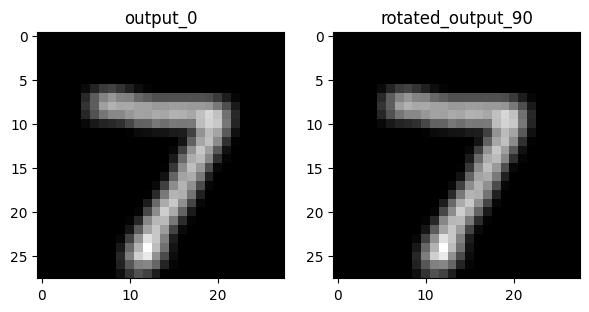

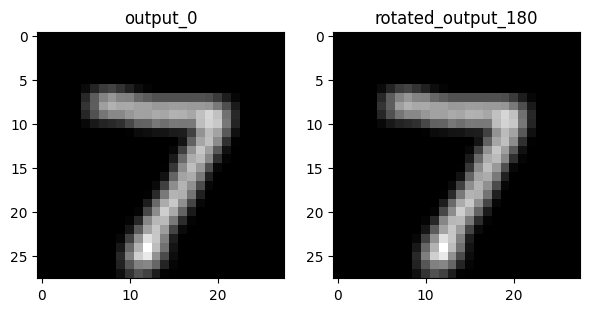

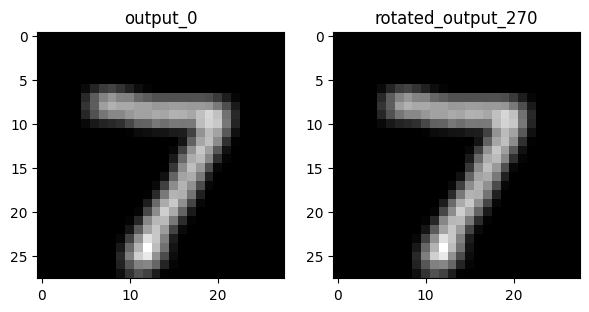

Mean absolute difference (0° vs 90°): 8.94964546915844e-10
Mean absolute difference (0° vs 180°): 9.713478910100548e-10
Mean absolute difference (0° vs 270°): 8.757978786633203e-10



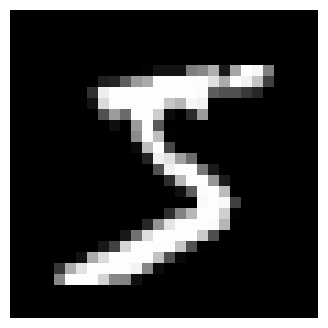

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.6778 - loss: 0.9385 - val_accuracy: 0.9179 - val_loss: 0.2584
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9440 - loss: 0.1814 - val_accuracy: 0.9401 - val_loss: 0.1808
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9678 - loss: 0.1005 - val_accuracy: 0.9496 - val_loss: 0.1658
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9802 - loss: 0.0596 - val_accuracy: 0.9475 - val_loss: 0.1747
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9852 - loss: 0.0443 - val_accuracy: 0.9554 - val_loss: 0.1424
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9883 - loss: 0.0318 - val_accuracy: 0.9565 - val_loss: 0.1625
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9909 - loss: 0.0240 - val_accuracy: 0.9570 - val_loss: 0.1607
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.9915 - loss: 0.0229 - 

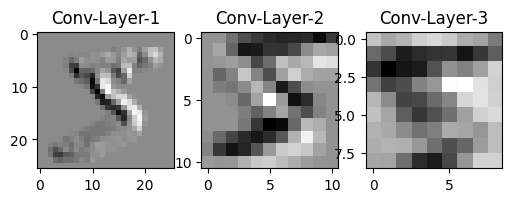

500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9929 - loss: 0.0186 - val_accuracy: 0.9591 - val_loss: 0.1584
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9943 - loss: 0.0168 - val_accuracy: 0.9591 - val_loss: 0.1641
Epoch 12/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9958 - loss: 0.0121 - val_accuracy: 0.9649 - val_loss: 0.1510
Epoch 13/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9972 - loss: 0.0083 - val_accuracy: 0.9600 - val_loss: 0.1711
Epoch 14/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9968 - loss: 0.0103 - val_accuracy: 0.9651 - val_loss: 0.1606
Epoch 15/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.9974 - loss: 0.0088 - val_accuracy: 0.9635 - val_loss: 0.1653
Epoch 16/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.9963 - loss: 0.0100 - val_accuracy: 0.9599 - val_loss: 0.1999
Epoch 17/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9950 - loss: 0.0139 - val_

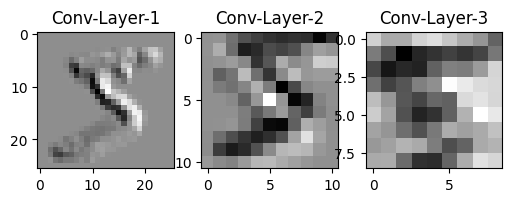

500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9978 - loss: 0.0064 - val_accuracy: 0.9669 - val_loss: 0.1675
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9630 - loss: 0.2065
Regular CNN - Test Loss: 0.23323826491832733, Test Accuracy: 0.9599999785423279
-----------------------------------
Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 112s 196ms/step - accuracy: 0.4616 - loss: 1.5035 - val_accuracy: 0.7201 - val_loss: 0.8609
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - accuracy: 0.7939 - loss: 0.6459 - val_accuracy: 0.8391 - val_loss: 0.5402
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 93s 185ms/step - accuracy: 0.8722 - loss: 0.4257 - val_accuracy: 0.8789 - val_loss: 0.4174
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 93s 187ms/step - accuracy: 0.9098 - loss: 0.3043 - val_accuracy: 0.8861 - val_loss: 0.3767
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 191ms/step - accuracy: 0.9274 - loss: 0.2459 - val_accuracy: 0.8895 - val_loss: 0.3692
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━

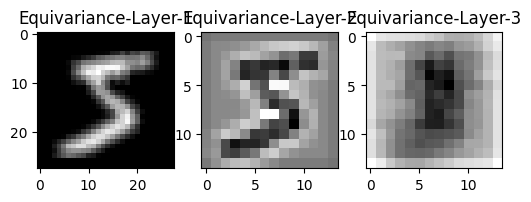

500/500 ━━━━━━━━━━━━━━━━━━━━ 94s 189ms/step - accuracy: 0.9734 - loss: 0.0801 - val_accuracy: 0.9229 - val_loss: 0.3042
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 105s 210ms/step - accuracy: 0.9751 - loss: 0.0729 - val_accuracy: 0.9285 - val_loss: 0.2628
Epoch 12/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 98s 196ms/step - accuracy: 0.9826 - loss: 0.0545 - val_accuracy: 0.9281 - val_loss: 0.2974
Epoch 13/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 192ms/step - accuracy: 0.9845 - loss: 0.0480 - val_accuracy: 0.9311 - val_loss: 0.3080
Epoch 14/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 95s 190ms/step - accuracy: 0.9861 - loss: 0.0418 - val_accuracy: 0.9355 - val_loss: 0.2850
Epoch 15/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 105s 210ms/step - accuracy: 0.9890 - loss: 0.0308 - val_accuracy: 0.9291 - val_loss: 0.3030
Epoch 16/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 93s 185ms/step - accuracy: 0.9924 - loss: 0.0237 - val_accuracy: 0.9285 - val_loss: 0.3516
Epoch 17/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 120s 240ms/step - accuracy: 0.9905 - loss: 0.

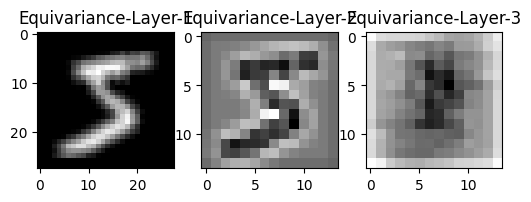

500/500 ━━━━━━━━━━━━━━━━━━━━ 101s 202ms/step - accuracy: 0.9938 - loss: 0.0184 - val_accuracy: 0.9168 - val_loss: 0.4923
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9285 - loss: 0.3478
Equivariant CNN - Test Loss: 0.4013851284980774, Test Accuracy: 0.9192500114440918


In [18]:
# Test equivariance property
diffs = test_equivariance()
print()

sample_input = x_train_rot[:1].reshape(1, 28, 28, 1)

plt.figure(figsize=(4, 4))
plt.imshow(sample_input[0], cmap='gray')
plt.axis('off')
plt.show()

viz_callback = ResponseMapVisualizationCallback(sample_input=sample_input, frequency=10)


# # Train and evaluate regular model
regular_history = regular_model.fit(
    x_train_rot, y_train_rot,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[viz_callback],
    verbose=1
    steps_per_epoch=128
)

regular_score = regular_model.evaluate(x_test_rot, y_test_rot)
print(f"Regular CNN - Test Loss: {regular_score[0]}, Test Accuracy: {regular_score[1]}")

print('-----------------------------------')

# Train and evaluate equivariant model
equivariant_history = eq_model.fit(
    x_train_rot, y_train_rot,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[viz_callback],
    verbose=1,
    steps_per_epoch=128
)

equivariant_score = eq_model.evaluate(x_test_rot, y_test_rot)
print(f"Equivariant CNN - Test Loss: {equivariant_score[0]}, Test Accuracy: {equivariant_score[1]}")


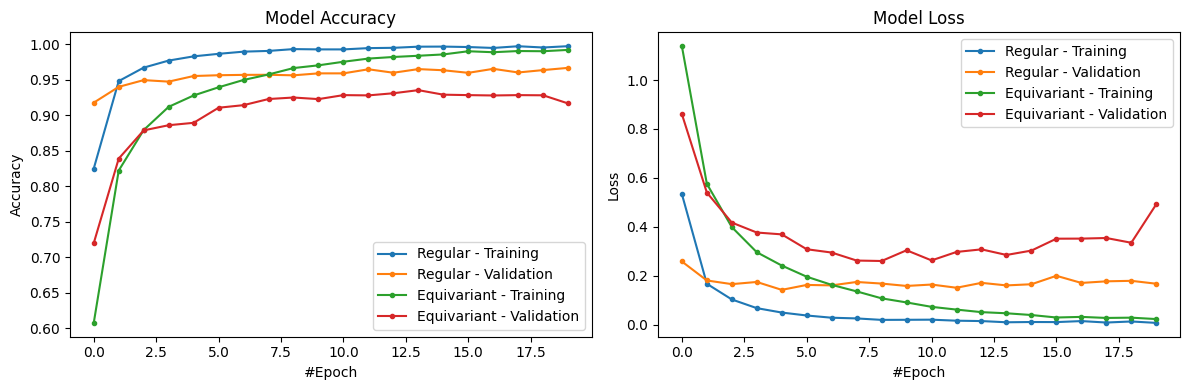

In [21]:
# Plot training histories
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(regular_history.history['accuracy'], label='Regular - Training', marker = '.')
plt.plot(regular_history.history['val_accuracy'], label='Regular - Validation', marker = '.')
plt.plot(equivariant_history.history['accuracy'], label='Equivariant - Training', marker = '.')
plt.plot(equivariant_history.history['val_accuracy'], label='Equivariant - Validation', marker = '.')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('#Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(regular_history.history['loss'], label='Regular - Training', marker = '.')
plt.plot(regular_history.history['val_loss'], label='Regular - Validation', marker = '.')
plt.plot(equivariant_history.history['loss'], label='Equivariant - Training', marker = '.')
plt.plot(equivariant_history.history['val_loss'], label='Equivariant - Validation', marker = '.')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('#Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('rotation_equivariant_performance.png')
plt.show()